In [1]:
# Simulation for SAT solving shardware
# reference: Shim, Chaeyun, Jooyoung Bae, and Bongjin Kim. "30.3 VIP-Sat: A Boolean Satisfiability Solver Featuring 5× 12 Variable In-Memory Processing Elements with 98% Solvability for 50-Variables 218-Clauses 3-SAT Problems." 2024 IEEE International Solid-State Circuits Conference (ISSCC). Vol. 67. IEEE, 2024.

In [2]:
# 데이터셋 위치  
# /data2/sat/uf50-218  
# /data2/sat/uf20-91 
# 출처: https://www.cs.ubc.ca/~hoos/SATLIB/benchm.html

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import copy 
import os
import re
import json
import datetime
from collections import defaultdict
import re

In [4]:
def count_files_in_directory(directory):
    try:
        # 폴더 내의 모든 파일 목록 가져오기
        files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
        return files
    except FileNotFoundError:
        print(f"Error: The directory '{directory}' does not exist.")
        return None


In [5]:
def read_cnf_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    clauses = []

    clause_save_start = False
    clause_count = 0
    for line in lines:
        if clause_save_start == True:
            clause = list(map(int, line.strip().split()))
            assert clause[-1] == 0
            clause = clause[:-1]  # Remove the trailing 0
            clauses.append(clause)
            clause_count += 1
            if clause_count == num_clauses:
                break

        if line.startswith(('p')) and clause_save_start == False:
            clause_save_start = True
            _, _, num_vars, num_clauses = line.split()
            num_vars = int(num_vars)
            num_clauses = int(num_clauses)
    assert clause_save_start == True

    clauses = np.array(clauses)
    return clauses, num_vars, num_clauses

In [6]:
class VPE:
    def __init__(self, MY_VAR):
        """
        VPE 초기화 메서드
        :param MY_VAR: 이 VPE가 담당할 변수 (예: v1, v2 등)
        """
        self._MY_VAR = MY_VAR  # 이 VPE가 처리할 변수
        self.MY_STATE = 1       # 변수의 상태 

        self.clauses = []         # 변수가 속한 절들의 리스트
        self.neighbors = set()    # 상관관계 있는 이웃 변수들

    @property # MY_VAR 속성은 읽기 전용
    def MY_VAR(self):
        return self._MY_VAR
    
    def add_clause(self, all_clauses):
        """
        변수가 속한 절을 추가하는 메서드
        :param all_clauses: 전체 절들의 리스트
        """
        clauses_clone = copy.deepcopy(all_clauses)
        for clause in clauses_clone:
            clause_abs = [abs(x) for x in clause]

            if self.MY_VAR in clause_abs:
                self_index = clause_abs.index(self.MY_VAR)
                temp = clause[self_index]
                #주인공이 앞에 오게 저장
                clause = np.concatenate((clause[:self_index], clause[self_index + 1:]))  # self_index에서 요소 제거
                clause_abs = clause_abs[:self_index] + clause_abs[self_index+1:]
                temp2 = np.insert(clause, 0, temp) 
                self.clauses.append(temp2) 

                # 절 내에서 다른 변수들을 이웃으로 추가
                for var_abs in clause_abs:
                    self.neighbors.add(var_abs)

        # assert len(self.clauses) <= 32, f'{len(self.clauses)}'
        if len(self.clauses) > 32:
            print('================================================================\n')
            print('================================================================\n')
            print('================================================================\n')
            print('================================================================\n')
            print('================================================================\n')
            print(f'32개 절 초과됨!!!! : Var{self._MY_VAR}에 {len(self.clauses)}개 추가됨.')
            print('================================================================\n')
            print('================================================================\n')
            print('================================================================\n')
            print('================================================================\n')
            print('================================================================\n')
            print('================================================================\n')
            
            # assert False
            
        # print('self._MY_VAR:', self._MY_VAR-1)
        # print('self.clauses:\n', np.abs(self.clauses)-1)
        # print('self.clauses unique:\n', len(np.unique(np.abs(self.clauses)-1)))
            
    def get_neighbors(self):
        """
        상관관계 있는 이웃 변수들을 반환하는 메서드
        """
        return list(self.neighbors)

    def process(self, var_state_array, stochastic_mode):
        """
        변수를 처리하는 메서드 (예: 값 업데이트 등)
        이 부분은 문제 해결 알고리즘에 따라 달라질 수 있음.
        """

        # Adder Tree
        tree_sum = 0

        non_trivial_clauses_count = 0.0 # VI가 중요한 절 개수
        up_count = 0.0
        down_count = 0.0

        # Clause Column
        # print(len(self.clauses),'개 연관 클로즈','v',self._MY_VAR-1)
        for clause in self.clauses:
            SI = 0 if clause[0] < 0 else 1 # 음수면 0, 양수면 1 
            SL = 0 if clause[1] < 0 else 1
            SR = 0 if clause[2] < 0 else 1

            VI = var_state_array[abs(clause[0])-1] # 현재 V값 가져오기
            VL = var_state_array[abs(clause[1])-1]
            VR = var_state_array[abs(clause[2])-1]

            assert VI == self.MY_STATE, f'{VI}, {self.MY_STATE}'

            # S와 V의 XOR값(같으면 0 다르면 1)이 3개가 나옴. (SIVI, SLVL, SRVR) 한개라도 XOR값이 0이어야 Clause satisfied.
            
            # Clause Logic
            if ((SL == 1 and VL == 0) or (SL == 0 and VL == 1)) and ((SR == 0 and VR == 1) or (SR == 1 and VR == 0)) == 1: 
                C0 = 1 # MY_VAR가 중요해졌다는 flag.
                C1 = 1 if SI == 0 else 0 # SI 토글
            else:
                C0 = 0
                C1 = 0

            # Adder Tree
            addi = 0
            if C0 == 1:
                non_trivial_clauses_count += 1.0
                if C1 == 1:
                    addi = -1
                    down_count += 1.0
                else: # C1 == 0
                    addi = 1
                    up_count += 1.0
            else: # C0 == 0
                addi = 0

            tree_sum = tree_sum + addi
            if self._MY_VAR-1 == 10:
                # print(f'clause[0]: {clause[0]}, clause[1]: {clause[1]}, clause[2]: {clause[2]}, C0: {C0}, C1: {C1}, SI: {SI}, SL: {SL}, VL: {VL}, SR: {SR}, VR: {VR}, VI: {VI}, addi: {addi}')
                pass
        # print('tree_sum',tree_sum,'\n')

        # Variable Update Logic
        if stochastic_mode == False:
            # DETERMINISTIC UPDATE MODE
            if tree_sum < 0:
                self.MY_STATE = 0
            elif tree_sum == 0:
                self.MY_STATE = 1 if self.MY_STATE == 0 else 0
                # pass
            elif tree_sum > 0:
                self.MY_STATE = 1
            else: 
                assert False
        else:
            # STOCHASTIC UPDATE MODE
            if tree_sum == 0:
                # self.MY_STATE = 1 if self.MY_STATE == 0 else 0 
                p = 1/2
            else:
                p = down_count/non_trivial_clauses_count
                
            if random.random() < p:
                self.MY_STATE = 0
            else:
                self.MY_STATE = 1

        return self.MY_STATE
    

In [7]:
class VPE_ARRAY:
    def __init__(self, my_seed=42,  num_rows=5, num_cols=12, clauses=[[1,2,-3],[2,-1,57]], num_vars=50, num_clauses=218, what_file='uf50-03'):
        """
        VPE_ARRAY 초기화 메서드
        :param num_rows: VPE 배열의 행 개수 (기본값: 5)
        :param num_cols: VPE 배열의 열 개수 (기본값: 12)
        :param clauses: 3-SAT 문제의 절(clause) 리스트
        :param num_vars: 변수의 총 개수
        :param num_clauses: 절의 총 개수
        """
        self.my_seed = my_seed
        self.num_rows = num_rows  # 행 개수
        self.clauses = clauses
        self.num_cols = num_cols  # 열 개수
        self.num_vars = num_vars  # 변수의 총 개수
        self.var_init_seed = my_seed
        self.what_file = what_file

        # 랜덤 시드 초기화
        random.seed(self.my_seed)

        # 상관 관계 행렬 
        self.correlation_matrix = self.create_correlation_matrix()

        # VPE 배열 생성
        self.VPES, self.VPE_index, self.assigned_abs_vars = self.assign_varaibles_to_vpe_with_file()
        # self.VPES, self.VPE_index, self.assigned_abs_vars = self.assign_variables_to_vpe()
        # self.VPES, self.VPE_index, self.assigned_abs_vars = self.assign_variables_to_vpe_shim()
        # self.VPES, self.VPE_index, self.assigned_abs_vars = self.assign_variables_to_vpe_light()

        # 딱 variable 개수만큼 배치 잘했는지 확인
        assert len(self.assigned_abs_vars) == self.num_vars, f'len(self.assigned_abs_vars): {len(self.assigned_abs_vars)}, self.num_vars: {self.num_vars}'
        assert sum(1 for i in range(self.num_rows) for j in range(self.num_cols) if self.VPES[i][j] is not None) == self.num_vars

        # 배치한 거 한번 보자
        # self.print_vpe_index()

        # uncorrelated columns check
        assert self.check_uncorrelated_columns(self.VPE_index, self.correlation_matrix)

        # VPE 배열에 모든 절 삽입
        self.add_clause_to_vpe()
        
        # variable state initialize
        self.var_state_array = self.variable_state_initialize()

        # deployment된 VPE들의 state값을 출력
        # self.print_var_state_array()
        
        # run
        # 외부에서 실행하세요.    


    def create_correlation_matrix(self):
        """
        상관 관계 행렬을 생성하는 메서드

        Args:
            clauses (list): 변수의 절(clause) 리스트
        """
        # 각 절(clause)에서 변수를 두 개씩 비교하며 상관 관계를 행렬에 기록
        correlation_matrix = np.zeros((self.num_vars, self.num_vars), dtype=int)
        for clause in self.clauses:
            for i, var1 in enumerate(clause):
                for var2 in clause[i + 1:]:
                    abs_var1, abs_var2 = abs(var1) - 1, abs(var2) - 1  # 변수 인덱스는 0부터 시작하므로 -1 처리
                    correlation_matrix[abs_var1, abs_var2] = 1  # 상관된 변수 간에는 1을 표시
                    correlation_matrix[abs_var2, abs_var1] = 1  # 상관 행렬은 대칭이므로 반대 방향도 동일하게 처리
        
        return correlation_matrix
    
    def assign_varaibles_to_vpe_with_file(self):
        # 사용한 변수를 추적하기 위한 리스트
        assigned_abs_vars = set()
        # 2D 어레이(행렬)로 VPE 배열 생성 (각 column에는 상관 관계가 없는 변수들 할당)
        VPES = [[None for col in range(self.num_cols)] for row in range(self.num_rows)]
        VPES_index = np.load(f'/home/bhkim003/SAT_AVLSI/mapping_box/vpe_index_for_{self.what_file}.npy', allow_pickle=True)
        for row in range(self.num_rows):
            for col in range(self.num_cols):
                if VPES_index[row][col] != None:
                    VPES[row][col] = VPE(VPES_index[row][col])
                    assigned_abs_vars.add(VPES_index[row][col])
        return VPES, VPES_index, assigned_abs_vars

    
    def assign_variables_to_vpe(self):
        assigned_abs_vars = set()

        deploy_search_iter = 0
        while True:
            deploy_search_iter += 1

            # 사용한 변수를 추적하기 위한 리스트
            assigned_abs_vars = set()

            # 2D 어레이(행렬)로 VPE 배열 생성 (각 column에는 상관 관계가 없는 변수들 할당)
            VPES = [[None for col in range(self.num_cols)] for row in range(self.num_rows)]
            VPES_index_past = np.array([[vpe.MY_VAR if vpe else None for vpe in row] for row in VPES])

            # Stage 1 : numvars//numcols 만큼의 row까지만 할당
            # 변수 할당을 위한 작업
            current_row_at_column = [0 for _ in range(self.num_cols)]
            for ii in range(1000):
                for col in range(self.num_cols):
                    if current_row_at_column[col] >= self.num_rows:  # 이 column에 모두 할당했으면 다음 column으로
                        continue
                    # 상관 관계가 없는 변수들을 찾음
                    shuffled_abs_vars_range = list(range(1, self.num_vars + 1))
                    random.shuffle(shuffled_abs_vars_range)
                    col_chance = 2
                    for abs_var in shuffled_abs_vars_range:
                        if abs_var in assigned_abs_vars:
                            continue # next var  # 이미 할당된 변수는 건너뜀

                        # 상관되지 않은 변수인지 확인
                        can_assign = True
                        for prev_row in range(current_row_at_column[col]):
                            prev_abs_var = VPES[prev_row][col].MY_VAR  # 이전에 같은 column에 배치된 변수
                            if self.correlation_matrix[abs_var - 1][prev_abs_var - 1] == 1:  # 상관된 변수면 할당 불가
                                can_assign = False
                                break # next var

                        if can_assign == True:
                            assert VPES[current_row_at_column[col]][col] == None
                            VPES[current_row_at_column[col]][col] = VPE(abs_var)  # 변수 할당
                            assigned_abs_vars.add(abs_var)  # 할당된 변수로 등록
                            current_row_at_column[col] += 1
                            col_chance -= 1 

                        # stage1_cut_row = self.num_vars//self.num_cols - 1
                        if current_row_at_column[col] == self.num_rows or col_chance == 0:  # 이 column에 어느 정도 할당했으면 다음 column으로
                            break # next col;
                    
                VPES_index_temp = np.array([[vpe.MY_VAR if vpe else None for vpe in row] for row in VPES])
                if np.array_equal(VPES_index_past, VPES_index_temp):
                    break
                else:
                    pass
                VPES_index_past = VPES_index_temp

            if len(assigned_abs_vars) == self.num_vars:
                # print('deploy_search_iter', deploy_search_iter)
                VPES_index = np.array([[vpe.MY_VAR if vpe else None for vpe in row] for row in VPES])
                break
        return VPES, VPES_index, assigned_abs_vars
    
    def assign_variables_to_vpe_shim(self):
        correlation_matrix_save = copy.deepcopy(self.correlation_matrix)
        assigned_abs_vars = set()
        deploy_search_iter = 0
        while True:
            # print('deploy_search_iter', deploy_search_iter)
            deploy_search_iter += 1
            self.correlation_matrix = copy.deepcopy(correlation_matrix_save)
            

            # 사용한 변수를 추적하기 위한 리스트
            assigned_abs_vars = set()

            # 2D 어레이(행렬)로 VPE 배열 생성 (각 column에는 상관 관계가 없는 변수들 할당)
            VPES = [[None for col in range(self.num_cols)] for row in range(self.num_rows)]
            VPES_index_past = np.array([[vpe.MY_VAR if vpe else None for vpe in row] for row in VPES])

            # 변수 할당을 위한 작업
            current_row_at_column = [0 for _ in range(self.num_cols)]
            for whole_col_iter in range(1000): # 모든 컬럼 반복 # 근데 어차피 이전 iter와 변화가 없으면 걍 break된다.
                # print('whole_col_iter', whole_col_iter)
                

                # 같은 숫자는 섞기
                # shuffled_abs_vars_range1 = np.concatenate([np.random.shuffle(group) or group for group in [np.where(self.correlation_matrix.sum(axis=1) == total)[0] for total in sorted(set(self.correlation_matrix.sum(axis=1)), reverse=True)]], axis=0) + 1 if np.random.seed((self.my_seed+1)*(whole_col_iter+1)*(deploy_search_iter+1)) is None else None
                shuffled_abs_vars_range5 = np.concatenate([np.sort(group)[::-1] for group in [np.where(self.correlation_matrix.sum(axis=1) == total)[0] for total in sorted(set(self.correlation_matrix.sum(axis=1)), reverse=True)]], axis=0) + 1 
                # 같은 숫자도 놔둬
                # shuffled_abs_vars_range2 = np.argsort(-self.correlation_matrix.sum(axis=1)) + 1
                # 걍 무조건 랜덤 
                # random.shuffle(shuffled_abs_vars_range3 := list(range(1, self.num_vars + 1)))
                # 이미 배치된 var와는 상관관계 버림.
                # self.correlation_matrix[:, list(assigned_abs_vars)] = 0
                # shuffled_abs_vars_range4 = np.argsort(-(self.correlation_matrix).sum(axis=1)) + 1
                
                shuffled_abs_vars_range = shuffled_abs_vars_range5
                if deploy_search_iter > 100:
                    shuffled_abs_vars_range = np.concatenate([np.random.shuffle(group) or group for group in [np.where(self.correlation_matrix.sum(axis=1) == total)[0] for total in sorted(set(self.correlation_matrix.sum(axis=1)), reverse=True)]], axis=0) + 1 if np.random.seed((self.my_seed+1)*(whole_col_iter+1)*(deploy_search_iter+1)) is None else None
                


                # combined_array = np.column_stack((shuffled_abs_vars_range-1, -np.sort(-self.correlation_matrix.sum(axis=1))))
                # for kkk in combined_array:
                #     print(kkk, end=' ')
                #     for lll in np.where(self.correlation_matrix[kkk[0]]==1)[0]:
                #         print(lll, end=' ')
                #     print()

                for col in range(self.num_cols):
                    if current_row_at_column[col] >= self.num_rows:  # 이 column에 모두 할당했으면 다음 column으로
                        continue
                    

                    # 상관 관계가 없는 변수들을 찾아서 같은 컬럼에 넣어!
                    col_chance = self.num_rows # 원하는 만큼 다 해 (한 컬럼에 한번에 몇개까지 넣을지)

                    for abs_var in shuffled_abs_vars_range:
                        if abs_var in assigned_abs_vars:
                            continue # next var  # 이미 할당된 변수는 건너뜀
                        

                        # 상관되지 않은 변수인지 확인
                        can_assign = True
                        for prev_row in range(current_row_at_column[col]):
                            prev_abs_var = VPES[prev_row][col].MY_VAR  # 이전에 같은 column에 배치된 변수
                            if self.correlation_matrix[abs_var - 1][prev_abs_var - 1] == 1:  # 상관된 변수면 할당 불가
                                can_assign = False
                                break # next var

                        if can_assign == True:
                            assert VPES[current_row_at_column[col]][col] == None
                            VPES[current_row_at_column[col]][col] = VPE(abs_var)  # 변수 할당
                            assigned_abs_vars.add(abs_var)  # 할당된 변수로 등록
                            current_row_at_column[col] += 1
                            col_chance -= 1 

                        # stage1_cut_row = self.num_vars//self.num_cols - 1
                        if current_row_at_column[col] == self.num_rows or col_chance == 0:  # 이 column에 어느 정도 할당했으면 다음 column으로
                            break # next col;
                
                VPES_index_temp = np.array([[vpe.MY_VAR if vpe else None for vpe in row] for row in VPES])
                if np.array_equal(VPES_index_past, VPES_index_temp) or len(assigned_abs_vars) == self.num_vars:
                    break
                else:
                    pass
                VPES_index_past = VPES_index_temp
            
            assert len(assigned_abs_vars) <= self.num_vars, f'ASSERT FALSE!! len(assigned_abs_vars): {len(assigned_abs_vars)}, self.num_vars: {self.num_vars}'
            if len(assigned_abs_vars) == self.num_vars:
                # print('deploy_search_iter', deploy_search_iter)
                VPES_index = np.array([[vpe.MY_VAR if vpe else None for vpe in row] for row in VPES])
                break
        return VPES, VPES_index, assigned_abs_vars

    
    def assign_variables_to_vpe_light(self):
        assigned_abs_vars = set()

        deploy_search_iter = 0
        while True:
            deploy_search_iter += 1

            # 사용한 변수를 추적하기 위한 리스트
            assigned_abs_vars = set()

            # 2D 어레이(행렬)로 VPE 배열 생성 (각 column에는 상관 관계가 없는 변수들 할당)
            VPES = [[None for col in range(self.num_cols)] for row in range(self.num_rows)]
            
            # Stage 1 : numvars//numcols 만큼의 row까지만 할당
            # 변수 할당을 위한 작업
            current_row_at_column = [0 for _ in range(self.num_cols)]
            for col in range(self.num_cols):
                if current_row_at_column[col] < self.num_rows:  # 이 column에 모두 할당했으면 다음 column으로
                    # 상관 관계가 없는 변수들을 찾음
                    shuffled_abs_vars_range = list(range(1, self.num_vars + 1))
                    random.shuffle(shuffled_abs_vars_range)
                    for abs_var in shuffled_abs_vars_range:
                        if abs_var in assigned_abs_vars:
                            continue # next var  # 이미 할당된 변수는 건너뜀

                        # 상관되지 않은 변수인지 확인
                        can_assign = True
                        for prev_row in range(current_row_at_column[col]):
                            prev_abs_var = VPES[prev_row][col].MY_VAR  # 이전에 같은 column에 배치된 변수
                            if self.correlation_matrix[abs_var - 1][prev_abs_var - 1] == 1:  # 상관된 변수면 할당 불가
                                can_assign = False
                                break # next var

                        if can_assign == True:
                            assert VPES[current_row_at_column[col]][col] == None
                            VPES[current_row_at_column[col]][col] = VPE(abs_var)  # 변수 할당
                            assigned_abs_vars.add(abs_var)  # 할당된 변수로 등록
                            current_row_at_column[col] += 1

                        # stage1_cut_row = self.num_vars//self.num_cols - 2
                        stage1_cut_row = self.num_vars//self.num_cols - 1
                        # stage1_cut_row = self.num_vars//self.num_cols
                        # stage1_cut_row = self.num_vars//self.num_cols + 1
                        if current_row_at_column[col] >= stage1_cut_row:  # 이 column에 어느 정도 할당했으면 다음 column으로
                            break # next col;

            # Stage 2: 나머지 row에 할당
            shuffled_col_list = list(range(self.num_cols))
            random.shuffle(shuffled_col_list)
            for col in shuffled_col_list:
                if current_row_at_column[col] >= self.num_rows:  # 이 column에 모두 할당했으면 다음 column으로
                    continue

                # 상관 관계가 없는 변수들을 찾음
                shuffled_abs_vars_range = list(range(1, self.num_vars + 1))
                random.shuffle(shuffled_abs_vars_range)
                for abs_var in shuffled_abs_vars_range:
                    if abs_var in assigned_abs_vars:
                        continue  # 이미 할당된 변수는 건너뜀

                    # 상관되지 않은 변수인지 확인
                    can_assign = True
                    for prev_row in range(current_row_at_column[col]):
                        prev_abs_var = VPES[prev_row][col].MY_VAR  # 이전에 같은 column에 배치된 변수
                        if self.correlation_matrix[abs_var - 1][prev_abs_var - 1] == 1:  # 상관된 변수면 할당 불가
                            can_assign = False
                            break

                    if can_assign == True:
                        VPES[current_row_at_column[col]][col] = VPE(abs_var)  # 변수 할당
                        assigned_abs_vars.add(abs_var)  # 할당된 변수로 등록
                        current_row_at_column[col] += 1

                    if current_row_at_column[col] >= self.num_rows:  # 이 column에 모두 할당했으면 다음 column으로
                        break
            
            if len(assigned_abs_vars) == self.num_vars:
                # print('deploy_search_iter', deploy_search_iter)
                VPES_index = np.array([[vpe.MY_VAR if vpe else None for vpe in row] for row in VPES])
                break
        return VPES, VPES_index, assigned_abs_vars

    def print_vpe_index(self):
        """
        VPE 배열을 2D 행렬로 출력하는 메서드
        """
        print('VPE Array:')
        for row_index, row in enumerate(self.VPE_index):
            # formatted_row = '| '.join(f'v{row_index * len(row) + col_index:<2} {str(elem) if elem is not None else "No":>2}' 
            #                             for col_index, elem in enumerate(row))
            formatted_row = '| '.join(f'v{str(elem-1) if elem is not None else "No":<2}' 
                                        for col_index, elem in enumerate(row))
            print(formatted_row)
        print('num of assigned_abs_vars:', len(self.assigned_abs_vars),'\n')
        

    def check_uncorrelated_columns(self, VPE_index, correlation_matrix):
        # VPE_index: VPE 배열의 인덱스를 나타냄. 각 값은 변수 번호를 의미함.
        # correlation_matrix: 변수들 간의 상관관계를 나타내는 행렬. (num_vars x num_vars 크기의 행렬)

        num_rows = len(VPE_index)
        # VPE_index의 행(row) 수를 얻음. 즉, VPE 배열에서 몇 개의 행이 있는지 확인.

        num_cols = len(VPE_index[0])
        # VPE_index의 열(column) 수를 얻음. 즉, 각 열에 몇 개의 변수가 배치되었는지 확인.

        for col in range(num_cols):
            # 각 열(column)을 순회함. 이때 col은 현재 처리 중인 열의 인덱스를 나타냄.

            col_values = [VPE_index[row][col] for row in range(num_rows) if VPE_index[row][col] is not None]
            # 현재 열에서 변수가 할당된 값을 모두 수집. None이 아닌 값만 선택하여 리스트로 만듦.
            # 즉, 해당 열에 배치된 변수 번호들을 수집하는 과정.

            for i in range(len(col_values)):
                # 수집한 변수 번호 리스트에서 첫 번째 변수부터 시작하여 다른 변수들과 비교하기 위해 반복문 시작.
                # i는 현재 비교하고자 하는 첫 번째 변수의 인덱스를 나타냄.

                for j in range(i + 1, len(col_values)):
                    # i 이후에 있는 변수들과 비교하기 위한 반복문.
                    # j는 두 번째로 비교할 변수의 인덱스를 나타냄.

                    var1 = col_values[i]
                    # 첫 번째 변수의 값(var1)을 col_values 리스트에서 가져옴.

                    var2 = col_values[j]
                    # 두 번째 변수의 값(var2)을 col_values 리스트에서 가져옴.

                    # 상관된 경우를 찾음
                    if correlation_matrix[var1 - 1][var2 - 1] == 1:
                        # correlation_matrix에서 var1과 var2가 상관된 경우를 확인.
                        # 변수 번호는 1부터 시작하므로, 0-based 인덱스에 맞추기 위해 -1 처리.
                        # 상관된 경우, correlation_matrix에서 해당 값이 1임을 이용하여 상관된 변수를 확인함.

                        # print(f"Error: Column {col+1} contains correlated variables {var1} and {var2}.")
                        # 상관된 변수를 발견한 경우, 그 변수가 어느 column에 있는지와 함께 에러 메시지를 출력.

                        return False
                        # 상관된 변수가 발견되면 더 이상 검사를 진행하지 않고 False를 반환하여 함수 종료.

        # 모든 열에 대해 상관된 변수가 없을 경우, 오류가 없음을 나타냄.
        # print("All columns are internally uncorrelated.\n")
        return True
        # 모든 열에서 상관된 변수가 없는 경우, True를 반환함.

    def add_clause_to_vpe(self):
        for row in range(self.num_rows):
            for col in range(self.num_cols):
                if self.VPES[row][col] != None:
                    self.VPES[row][col].add_clause(self.clauses)

    
    def variable_state_initialize(self):
        self.var_init_seed = self.my_seed
        random.seed(self.var_init_seed)
        var_state_array = [random.choice([0, 1]) for _ in range(self.num_vars)]

        for row in range(self.num_rows):
            for col in range(self.num_cols):
                if self.VPES[row][col] != None:
                    self.VPES[row][col].MY_STATE = var_state_array[self.VPES[row][col].MY_VAR - 1]
        return var_state_array
    


    def satisfy_check(self, var_state_array, clauses):
        """
        절을 만족하는지 확인하는 메서드
        :param var_state_array: 변수들의 상태를 나타내는 배열 (0 또는 1로 구성된 리스트)
        :param clauses: 각 절을 표현하는 리스트의 리스트 (변수는 양수 또는 음수로 표현됨)
        :return: num_unsat_clause, unsat_clauses_list (만족되지 않은 절의 개수와 그 절들의 리스트)
        """
        unsat_clauses_list = []
        # 각 절에 대해 만족 여부를 확인
        for clause in clauses:
            satisfied = False  # 해당 절이 만족되는지 여부를 나타내는 변수

            for var in clause:
                abs_var = abs(var) - 1  # 변수의 절대값으로 인덱스를 맞춤 (0부터 시작)
                var_state = var_state_array[abs_var]  # 해당 변수의 상태

                if (var > 0 and var_state == 1) or (var < 0 and var_state == 0):
                    satisfied = True  
                    break # 하나라도 만족하는 변수가 있으면 절이 만족됨

            if satisfied == False:
                unsat_clauses_list.append(clause)  # 만족되지 않은 절을 리스트에 추가

        num_unsat_clause = len(unsat_clauses_list)  # 만족되지 않은 절의 개수

        return num_unsat_clause, unsat_clauses_list
    
    def print_var_state_array(self):
        # for row in range(self.num_rows):
        #     for col in range(self.num_cols):
        #         if self.VPE_index[row][col] != None:
        #             print(f'v{row * self.num_cols + col:<2} {self.VPE_index[row][col]:<2}={self.var_state_array[self.VPE_index[row][col]-1]}', end=' | ')
        #         else: 
        #             print(f'None    ', end=' | ')
        #     print()

        for col in range(self.num_cols):
            print(f'col{col:>2}', end='|||')
        print()

        for row in range(self.num_rows):
            for col in range(self.num_cols):
                if self.VPE_index[row][col] != None:
                    print(f'v{self.VPE_index[row][col]-1:<2}={self.var_state_array[self.VPE_index[row][col]-1]}', end=' | ')
                else: 
                    print(f'None ', end=' | ')
            print()

        # f = open(f'sat_init_condition/{self.what_file}_init_condition.txt', 'w')  # 파일 열기
        # for row in range(self.num_rows):
        #     for col in range(self.num_cols):
        #         if self.VPE_index[row][col] != None:
        #             f.write(f'v{row * self.num_cols + col:<2} {self.VPE_index[row][col]:<2}={self.var_state_array[self.VPE_index[row][col]-1]} | ')
        #         else: 
        #             f.write(f'None     | ')
        #     f.write('\n')
        # f.close()
        
        # f_all = open(f'sat_init_condition/all_init_condition.txt', 'a')  # 파일 열기
        # problem_integer = int(re.search(r'-(\d+)', self.what_file).group(1))
        # f_all.write(f'\nmy %map{problem_integer} = (\n    ')
        # for row in range(self.num_rows):
        #     for col in range(self.num_cols):
        #         if self.VPE_index[row][col] != None:
        #             f_all.write(f'\'{self.VPE_index[row][col]:<2}\' => \'{row * self.num_cols + col}\', ')
        #         else:
        #             f_all.write(f'\'99\' => \'{row * self.num_cols + col}\', ')
        #     f_all.write('\n    ') if row != self.num_rows-1 else f.write('\n')
        # f_all.write(f'\n);\n\n')
        # f_all.close()
        
        # f_all_value = open(f'sat_init_condition/all_init_value.txt', 'a')  # 파일 열기
        # problem_integer = int(re.search(r'-(\d+)', self.what_file).group(1))
        # for row in range(self.num_rows):
        #     f_all_value.write(f'`define INIT_VAR{row}_PRO{problem_integer} \'{{')
        #     for col in range(self.num_cols):
        #         if self.VPE_index[row][col] != None:
        #             f_all_value.write(f'{self.var_state_array[self.VPE_index[row][col]-1]}')
        #         else:
        #             f_all_value.write(f'{0}')

        #         f_all_value.write(', ') if col != self.num_cols-1 else f_all_value.write('}')

                
        #     f_all_value.write('\n')
        # f_all_value.write(f'\n\n')
        # f_all_value.close()



    def run(self, max_iter, iter_verbose, stochastic_mode_start_iter):
        """
        VPE 배열을 실행하는 메서드
        :param max_iter: 최대 반복 횟수 (기본값: 100)
        """
        num_unsat_clause, unsat_clauses_list = self.satisfy_check(self.var_state_array, self.clauses)

        # if iter_verbose == True or True:
        if iter_verbose == True :
            print('INITIAL VAR STATE ARRAY')
            print(f'iteration {0:>4} | num_unsat_clause: {num_unsat_clause}')
            self.print_var_state_array()
        for i in range(max_iter):
            # row-wise parellel processing
            for col in range(self.num_cols):
                state_temp_at_now_col = [None for _ in range(self.num_rows)]
                for row in range(self.num_rows):
                    if self.VPES[row][col] != None:

                        stochastic_mode = True if i+1 >= stochastic_mode_start_iter else False
                        state_temp_at_now_col[row] = self.VPES[row][col].process(self.var_state_array,stochastic_mode)

                # updated state update!!
                toggle_count = 0
                for row in range(self.num_rows):
                    if state_temp_at_now_col[row] != None:  
                        if self.var_state_array[self.VPES[row][col].MY_VAR - 1] != state_temp_at_now_col[row]:
                            toggle_count += 1
                        self.var_state_array[self.VPES[row][col].MY_VAR - 1] = state_temp_at_now_col[row]

                        
                if iter_verbose == True:
                    num_unsat_clause, unsat_clauses_list = self.satisfy_check(self.var_state_array, self.clauses)
                    print(f'\n\niter {i+1}- col {col} done, toggle_count: {toggle_count}' )
                    print(f'iteration {i+1:>4} | num_unsat_clause: {num_unsat_clause}')
                    self.print_var_state_array()

            num_unsat_clause, unsat_clauses_list = self.satisfy_check(self.var_state_array, self.clauses)


            if num_unsat_clause == 0:
                return i+1
            
            # iteration 마다 실패하면 다시 리셋하기 (근데 이러면 solvability 0)
            # self.var_state_array = self.variable_state_initialize()


        else:
            if iter_verbose == True:
                print(f"NOT SATISFIED! num_unsat_clause: {num_unsat_clause}, unsat_clauses_list: {unsat_clauses_list}, iteration: {i+1}")
            return -num_unsat_clause



In [8]:

def HYPER_RUN(HYPER_MAX_ITER=1, hyper_seed=42, num_rows=5, num_cols=18, file_path='/data2/sat/uf50-218/uf50-03.cnf', max_iter=100, iter_verbose=False, stochastic_mode_start_iter=9999999):
    clauses, num_vars, num_clauses = read_cnf_file(file_path)

    SUCCESS_OR_NOT = 0
    for hyper_iter in range(HYPER_MAX_ITER):
        # print(f'hyper_iter: {hyper_iter+1}', end = '  ')
        my_seed = hyper_seed * (hyper_iter+1)
        what_file = os.path.splitext(os.path.basename(file_path))[0]
        vpe_array = VPE_ARRAY(my_seed=my_seed, num_rows=num_rows, num_cols=num_cols, clauses=clauses, num_vars=num_vars, num_clauses=num_clauses, what_file=what_file)  # 5x12 VPE 배열 생성
        success_iter = vpe_array.run(max_iter, iter_verbose, stochastic_mode_start_iter)  # VPE processing 실행
        assert success_iter != 0, 'run메서드에서는 0이 나올 수는 없게 해놨다.'
        
        if success_iter > 0:
            print(f'SATISFIED!!!! hyper_iter: {hyper_iter+1}, success_iter: {success_iter}')
            SUCCESS_OR_NOT = success_iter # 양수면 성공임
            break
        # print(f'not satisfied. num_unsat_clause: {-success_iter}')
        # print()
    else:
        print(f'NOT SATISFIED! HYPER_MAX_ITER: {HYPER_MAX_ITER},  last num_unsat_clause: {-success_iter}')

    return SUCCESS_OR_NOT, hyper_iter

    # vpe_array.print_vpe_index()  # VPE 배열 출력

In [9]:

# HYPER_MAX_ITER = 1

# # file_path = 'example_uf50-03.cnf'
# file_path = '/data2/sat/uf50-218/uf50-02.cnf'
# hyper_seed = 42
# num_rows = 5
# num_cols = 12
# max_iter = 100
# iter_verbose = False

# # HYPER_RUN(HYPER_MAX_ITER=HYPER_MAX_ITER, hyper_seed=hyper_seed, num_rows=num_rows, num_cols=num_cols, file_path=file_path, max_iter=max_iter, iter_verbose=iter_verbose)

In [10]:


def FULL_FILE_RUN(HYPER_MAX_ITER=1, hyper_seed=42, num_rows=5, num_cols=12, BASE_PATH='/data2/sat/uf50-218/', max_iter=10, iter_verbose=False, max_problem = 1000, stochastic_mode_start_iter = 9999999, current_time="20241026_025657"):
    # 설정 값을 딕셔너리 형태로 저장
    config = {
        "HYPER_MAX_ITER": HYPER_MAX_ITER,
        "hyper_seed": hyper_seed,
        "num_rows": num_rows,
        "num_cols": num_cols,
        "BASE_PATH": BASE_PATH,
        "max_iter": max_iter,
        "iter_verbose": iter_verbose,
        "max_problem": max_problem,
        "stochastic_mode_start_iter": stochastic_mode_start_iter,
        "current_time": current_time
    }

    success_file_list = []
    fail_file_list = []
    
    # config.json 파일로 저장
    folder_name = os.path.basename(os.path.normpath(BASE_PATH))  # 마지막 폴더 이름을 추출합니다.
    iter_save_path = os.path.join(f'iter_save_box/{folder_name}_iter_analysis_{current_time}')

    with open(iter_save_path + '.json', 'w') as config_file:
        json.dump(config, config_file, indent=4)  # JSON 형식으로 저장하며, 들여쓰기를 설정합니다.


    files = count_files_in_directory(BASE_PATH)
    assert files != None, '파일 못 불러오고 있따.'
    
    # 파일 이름에서 숫자만 추출하여 정렬
    def extract_number(file_name):
        numbers = re.findall(r'\d+', file_name) # 파일 이름에서 숫자를 추출
        # print(numbers)
        return int(numbers[-1]) if numbers else float('inf')  # 숫자가 없는 파일을 뒤로 정렬
    
    files.sort(key=extract_number)  # 파일 이름을 숫자 순으로 정렬
    
    total_file = len(files)
    num_success = 0
    current_file = 0

    success_iter_list = []
    for file in files:
        # if file != 'uf50-03.cnf':
        #     continue
        # if file != 'uf50-025.cnf':
        #     continue
        current_file += 1
        file_path = os.path.join(BASE_PATH, file)
        print(f'\nfile: {file}, {current_file}/{max_problem}   (real total: {total_file})')

        SUCCESS_OR_NOT, hyper_iter= HYPER_RUN(HYPER_MAX_ITER=HYPER_MAX_ITER, hyper_seed=hyper_seed, num_rows=num_rows, num_cols=num_cols, file_path=file_path, max_iter=max_iter, iter_verbose=iter_verbose, stochastic_mode_start_iter=stochastic_mode_start_iter)
        # SUCCESS_OR_NOT가 양수면 성공(성공한 iter 수), 음수면 실패(불만족하는 clause 수)
        if SUCCESS_OR_NOT > 0:
            num_success += 1
            iter = SUCCESS_OR_NOT
            success_iter_list.append((min(total_file, max_problem), current_file, iter, hyper_iter))
            success_file_list.append(file)
        else:
            fail_file_list.append(file)
        print(f'Current Solvability: {100*num_success/current_file:.2f}%')
        
        if max_problem == current_file:
            break
    print(f'\n\nFinal Solvability: {100*num_success/current_file:.2f}%')
    print(f'')
    print(f'success_file_list: {success_file_list}')
    print(f'fail_file_list: {fail_file_list}')
    success_iter_array = np.array(success_iter_list, dtype=int)  # 정수형 배열로 변환
    np.save(iter_save_path , success_iter_array)  # NumPy 형식으로 저장

    # final solvability
    return num_success/current_file

In [11]:
HYPER_MAX_ITER = 11

BASE_PATH = '/data2/sat/uf50-218/'
# BASE_PATH = '/data2/sat/uf20-91'
hyper_seed = 50
num_rows = 5
num_cols = 12
max_iter = 50
iter_verbose = False # True # False
max_problem = 100
stochastic_mode_start_iter = 9999999    #1    #9999999    #stochastic할 거면 1로 설정 
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
print(f'current_time: {current_time}')

solv_list = []
for i in range(1,50):
    print(f'\n\n\n\n\n\n\n\n{i}\n\n\n\n\n')

    solvability = FULL_FILE_RUN(HYPER_MAX_ITER=HYPER_MAX_ITER, 
                    hyper_seed=i, 
                    num_rows=num_rows, 
                    num_cols=num_cols, 
                    BASE_PATH=BASE_PATH, 
                    max_iter=max_iter, 
                    iter_verbose=iter_verbose,
                    max_problem=max_problem,
                    stochastic_mode_start_iter=stochastic_mode_start_iter,
                    current_time=current_time)
    solv_list.append(solvability)
    print(f'solvability: {solvability*100:.2f}')
    
print(max(solv_list))

current_time: 20241213_195147








1






file: uf50-01.cnf, 1/100   (real total: 1000)


SATISFIED!!!! hyper_iter: 6, success_iter: 40
Current Solvability: 100.00%

file: uf50-02.cnf, 2/100   (real total: 1000)
NOT SATISFIED! HYPER_MAX_ITER: 11,  last num_unsat_clause: 2
Current Solvability: 50.00%

file: uf50-03.cnf, 3/100   (real total: 1000)
SATISFIED!!!! hyper_iter: 1, success_iter: 8
Current Solvability: 66.67%

file: uf50-04.cnf, 4/100   (real total: 1000)
SATISFIED!!!! hyper_iter: 3, success_iter: 9
Current Solvability: 75.00%

file: uf50-05.cnf, 5/100   (real total: 1000)
SATISFIED!!!! hyper_iter: 1, success_iter: 7
Current Solvability: 80.00%

file: uf50-06.cnf, 6/100   (real total: 1000)
NOT SATISFIED! HYPER_MAX_ITER: 11,  last num_unsat_clause: 1
Current Solvability: 66.67%

file: uf50-07.cnf, 7/100   (real total: 1000)
SATISFIED!!!! hyper_iter: 1, success_iter: 14
Current Solvability: 71.43%

file: uf50-08.cnf, 8/100   (real total: 1000)
SATISFIED!!!! hyper_iter: 7, success_iter: 24
Current Solvability: 75.00%

file: uf50-09.cnf, 9/100   (real total: 1000)
SATI

In [12]:
# NumPy로 저장
np.save(f'solv_list_{current_time}.npy', solv_list)
print("List saved to 'solv_list.npy'")

# NumPy로 로드
loaded_solv_list = np.load(f'solv_list_{current_time}.npy')

# 통계값 계산
mean_val = np.mean(loaded_solv_list)
min_val = np.min(loaded_solv_list)
max_val = np.max(loaded_solv_list)

# 출력
print(f"Mean: {mean_val}, Min: {min_val}, Max: {max_val}")


List saved to 'solv_list.npy'
Mean: 0.9424489795918367, Min: 0.89, Max: 0.99


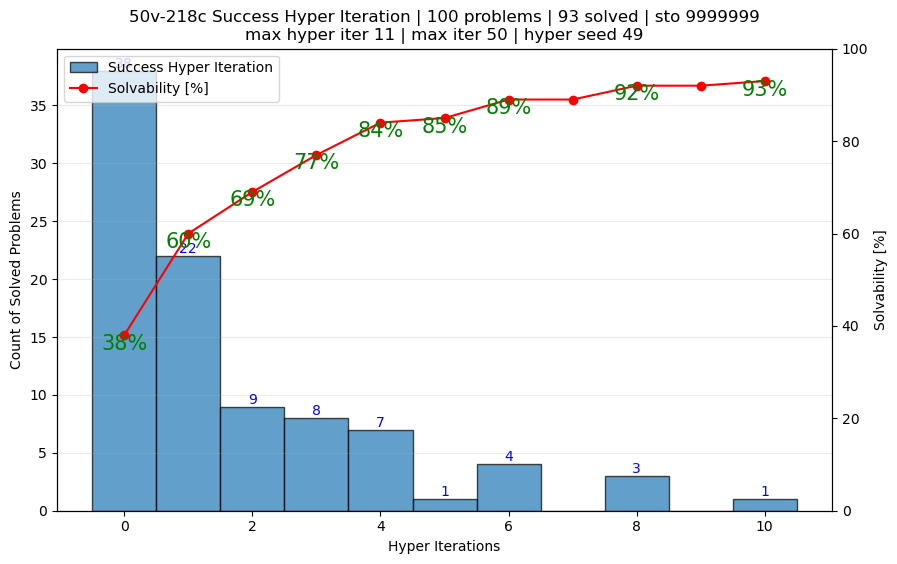

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import copy
import os
import re
import json
import datetime

def plot_success_distribution(iter_save_path):
    # 설정 파일을 읽어 설정 값을 로드하는 함수입니다.
    config_path = iter_save_path + '.json'
    numpy_path = iter_save_path + '.npy'
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Configuration file not found: {config_path}")

    with open(config_path, 'r') as config_file:
        config = json.load(config_file)  # JSON 형식으로 저장된 설정 값을 불러옵니다.

    # 저장된 NumPy 배열을 로드합니다.
    success_iter_array = np.load(numpy_path)  # 지정된 경로에서 NumPy 배열을 불러옵니다.

    # 숫자 50과 218을 추출하는 정규 표현식
    numbers = re.findall(r'\d+', numpy_path)
    # 추출된 숫자 확인
    if len(numbers) >= 2:
        variable_num, clause_num = numbers[0], numbers[1]
    else:
        assert False, "No matching numbers found."

    # 성공적인 반복 수를 추출합니다.
    assert len(success_iter_array) > 0, "No successful iteration found."
    success_counts = success_iter_array[:, 2]  # SUCCESS_OR_NOT가 저장된 열을 선택하여 성공적인 반복 수를 가져옵니다.
    total_problems = success_iter_array[0][0]  # 전체 문제 수를 가져옵니다.
    solved_files = success_iter_array.shape[0]  # 전체 파일 수를 계산합니다.

    # 분포도 그리기
    fig, ax1 = plt.subplots(figsize=(10, 6))  # 그래프의 크기를 10x6 인치로 설정합니다.

    # y축 방향의 grid를 가장 뒤에 배치
    ax1.grid(axis='y', alpha=0.25, zorder=0)  # y축 방향으로 그리드를 추가하고 가장 뒤로 설정합니다.

    # 히스토그램 생성
    z = 0.5  # 막대의 중앙을 맞추기 위한 오프셋
    counts, bins, patches = ax1.hist(
        success_counts, bins=np.arange(0, np.max(success_counts) + 2) - z, 
        edgecolor='black', alpha=0.7, label='Success Iteration', zorder=1
    )
    # 제목과 축 레이블 설정
    ax1.set_title(f'{variable_num}v-{clause_num}c Success Iteration | {total_problems} problems | {solved_files} solved | sto {config["stochastic_mode_start_iter"]}\nmax hyper iter {config["HYPER_MAX_ITER"]} | max iter {config["max_iter"]} | hyper seed {config["hyper_seed"]}')  # 그래프 제목을 설정합니다.
    ax1.set_xlabel('Iterations')  # x축 레이블을 'Iterations'로 설정합니다.
    ax1.set_ylabel('Count of Solved Problems')  # y축 레이블을 'Count of Solved Problems'로 설정합니다.
    ax1.set_xticks(np.arange(0, np.max(success_counts) + 2, step=bins.shape[0]//10+1))  # 예시로 step=5로 설정하였으므로 필요에 따라 변경 가능
    ax1.yaxis.get_major_locator().set_params(integer=True) # y축 눈금을 정수만 표시

    # 막대 위에 빈도 수 표시
    for count, patch in zip(counts, patches):
        if count > 0:
            ax1.text(patch.get_x() + patch.get_width() / 2, count, str(int(count)), ha='center', va='bottom', color='blue')
        # 각 막대의 상단 중앙에 빈도 수를 표시합니다.

    # 누적 비율을 계산하여 꺾은선 그래프 추가
    accumulated_count = 0
    cumulative_proportions = []  # 누적 비율을 저장할 리스트를 초기화합니다.
    for count in counts:  
        accumulated_count += count
        proportion = accumulated_count / total_problems  # 전체 문제 수에 대한 푼 문제 수의 비율을 계산합니다.
        cumulative_proportions.append(proportion*100)  # 계산된 비율을 리스트에 추가합니다.

    # 꺾은선 그래프의 2차 y축 생성
    ax2 = ax1.twinx()
    ax2.plot(bins[:-1] + z, cumulative_proportions, color='red', marker='o', linestyle='-', label='Solvability [%]', zorder=3)  
    ax2.set_ylim(0, 100)  # y축 범위를 0에서 1로 설정하여 누적 비율 그래프의 범위를 조정합니다.
    ax2.set_ylabel('Solvability [%]')  # 꺾은선 그래프의 y축 레이블을 설정합니다.

    # 꺾은선 그래프 포인트 위에 비율 표시
    past_proportion = 0
    for x, proportion in zip(bins[:-1] + z, cumulative_proportions):
        if proportion != past_proportion:
            ax2.text(x, proportion-4, f"{proportion:.0f}%", ha='center', va='bottom', color='green', fontsize=15)  
        past_proportion = proportion
        # 각 꺾은선 그래프 포인트 위에 비율을 표시하며, 비율은 소수점 둘째 자리까지 나타냅니다.

    fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
    plt.show()  # 그래프를 화면에 표시합니다.


def plot_success_distribution_hyper(iter_save_path):

    # 설정 파일을 읽어 설정 값을 로드하는 함수입니다.
    config_path = iter_save_path + '.json'
    numpy_path = iter_save_path + '.npy'
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Configuration file not found: {config_path}")

    with open(config_path, 'r') as config_file:
        config = json.load(config_file)  # JSON 형식으로 저장된 설정 값을 불러옵니다.



    # 저장된 NumPy 배열을 로드합니다.
    success_iter_array = np.load(numpy_path)  # 지정된 경로에서 NumPy 배열을 불러옵니다.

    # 숫자 50과 218을 추출하는 정규 표현식
    numbers = re.findall(r'\d+', numpy_path)
    # 추출된 숫자 확인
    if len(numbers) >= 2:
        variable_num, clause_num = numbers[0], numbers[1]
    else:
        assert False, "No matching numbers found."

    # 성공적인 반복 수를 추출합니다.
    success_counts = success_iter_array[:, 3]  # hyper_iter
    total_problems = success_iter_array[0][0]  # 전체 문제 수를 가져옵니다.
    solved_files = success_iter_array.shape[0]  # 전체 파일 수를 계산합니다.

    # 분포도 그리기
    fig, ax1 = plt.subplots(figsize=(10, 6))  # 그래프의 크기를 10x6 인치로 설정합니다.

    # y축 방향의 grid를 가장 뒤에 배치
    ax1.grid(axis='y', alpha=0.25, zorder=0)  # y축 방향으로 그리드를 추가하고 가장 뒤로 설정합니다.

    # 히스토그램 생성
    z = 0.5  # 막대의 중앙을 맞추기 위한 오프셋
    counts, bins, patches = ax1.hist(
        success_counts, bins=np.arange(0, np.max(success_counts) + 2) - z, 
        edgecolor='black', alpha=0.7, label='Success Hyper Iteration', zorder=1
    )
    
    # 제목과 축 레이블 설정
    ax1.set_title(f'{variable_num}v-{clause_num}c Success Hyper Iteration | {total_problems} problems | {solved_files} solved | sto {config["stochastic_mode_start_iter"]}\nmax hyper iter {config["HYPER_MAX_ITER"]} | max iter {config["max_iter"]} | hyper seed {config["hyper_seed"]}')  
    ax1.set_xlabel('Hyper Iterations')  # x축 레이블을 'Iterations'로 설정합니다.
    ax1.set_ylabel('Count of Solved Problems')  # y축 레이블을 'Count of Solved Problems'로 설정합니다.
    ax1.set_xticks(np.arange(0, np.max(success_counts) + 2, step=bins.shape[0]//10+1))  # 예시로 step=5로 설정하였으므로 필요에 따라 변경 가능
    ax1.yaxis.get_major_locator().set_params(integer=True) # y축 눈금을 정수만 표시

    # 막대 위에 빈도 수 표시
    for count, patch in zip(counts, patches):
        if count > 0:
            ax1.text(patch.get_x() + patch.get_width() / 2, count, str(int(count)), ha='center', va='bottom', color='blue')
        # 각 막대의 상단 중앙에 빈도 수를 표시합니다.

    # 누적 비율을 계산하여 꺾은선 그래프 추가
    accumulated_count = 0
    cumulative_proportions = []  # 누적 비율을 저장할 리스트를 초기화합니다.
    for count in counts:  
        accumulated_count += count
        proportion = accumulated_count / total_problems  # 전체 문제 수에 대한 푼 문제 수의 비율을 계산합니다.
        cumulative_proportions.append(proportion*100)  # 계산된 비율을 리스트에 추가합니다.

    # 꺾은선 그래프의 2차 y축 생성
    ax2 = ax1.twinx()
    ax2.plot(bins[:-1] + z, cumulative_proportions, color='red', marker='o', linestyle='-', label='Solvability [%]', zorder=3)  
    ax2.set_ylim(0, 100)  # y축 범위를 0에서 1로 설정하여 누적 비율 그래프의 범위를 조정합니다.
    ax2.set_ylabel('Solvability [%]')  # 꺾은선 그래프의 y축 레이블을 설정합니다.

    # 꺾은선 그래프 포인트 위에 비율 표시
    past_proportion = 0
    for x, proportion in zip(bins[:-1] + z, cumulative_proportions):
        if proportion != past_proportion:
            ax2.text(x, proportion-4, f"{proportion:.0f}%", ha='center', va='bottom', color='green', fontsize=15)  
        past_proportion = proportion
        # 각 꺾은선 그래프 포인트 위에 비율을 표시하며, 비율은 소수점 둘째 자리까지 나타냅니다.

    fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
    plt.show()  # 그래프를 화면에 표시합니다.


# 사용 예시
iter_save_path = f'iter_save_box/uf50-218_iter_analysis_{current_time}'  # 파일 경로를 지정합니다.
# plot_success_distribution(iter_save_path)  # 지정된 경로의 파일을 사용하여 분포도를 그립니다.
plot_success_distribution_hyper(iter_save_path)  # 지정된 경로의 파일을 사용하여 분포도를 그립니다.
